In [1]:
import pandas as pd
df = pd.read_csv('sample_laudos_1.csv')

# Análise dos Dados

In [2]:
df.isna().sum()

docid             0
modalidade        0
tipo_exame        0
laudo_completo    0
dtype: int64

<b>Acima podemos observar que não a presença de dados nulos no dataset, próximo passo checar duplicações no dataset utilizando a coluna docid</b>

In [3]:
print(df['docid'].shape[0]-len(df['docid'].unique()))

38


<b>Existe um conjunto de 38 laudos que tem o docid repetido, esses documentos serão desconsiderados para as próximas etapas de análises</b>

In [4]:
df = df.drop_duplicates(subset=['docid'], keep='first')

In [5]:
print(df.shape[0])
df.head()

4962


,docid,modalidade,tipo_exame,laudo_completo
0,189988,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,o estudo tomográfico computadorizado do tórax ...
1,376443,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,realizados cortes tomográficos axiais com técn...
2,1843933,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,tecnica: \n o estudo tomográfico computadoriza...
3,454421,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,o estudo tomográfico computadorizado do tórax ...
4,61595,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,realizada tomografia computadorizada do tórax ...


<b>Restaram 4962 para as análises posteriores. A proximas análise será focada na distribuição dos laudos em relação ao tipo e modalidade de exame, para assim poder entender um pouco melhor como é o dado a ser trabalhado.</b>

## Análise exploratória dos dados.

In [6]:
import seaborn as sns
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import re
import unidecode
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from sklearn.decomposition import PCA

nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')
class Vizualization():
    def __init__(self):
        pass
    
    def bar_plot(self,df, column, rotation):
        ax = sns.countplot(x=column, data=df, palette="Blues_d")
        ax.set_xticklabels(labels=df[column].unique(),rotation=rotation)
   
    def pie_chart_multy(self, df):
        fig, ax = plt.subplots(2,2, figsize=(14, 14))
        i = 0 
        j = 0
        for modality in df['modalidade'].unique():
            current_modality = df[df['modalidade']==modality]
            labels = current_modality['tipo_exame'].value_counts().index
            values = current_modality['tipo_exame'].value_counts().values
            ax[i, j].pie(values, autopct=lambda pct: self.func(pct, values))
            ax[i, j].legend(labels,
                      title=modality,
                      loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))
            if j == 1:
                i=+1
                j=-1
            j+=1
        plt.subplots_adjust(bottom=0.25, right=1.5)
        plt.show()
    
    def scatter_mult(self, words, model):
        fig, ax = plt.subplots(3, 3, figsize=(14, 14))
        i = 0
        j = 0
        k = 0
        l=0
        for word in words: 
            similarity = model.most_similar(positive=[word])
            similar_words = [s[0] for s in similarity]
            distance = [s[1] for s in similarity]
            X = model[similar_words]
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            df2 = pd.DataFrame(X_pca, index=similar_words, columns=['x', 'y'])
            for color in ['darkorange', 'lime', 'silver', 'salmon', 'peru', 'violet', 'aqua', 'gold', 'pink', 'lightcoral']:
                ax[i, j].scatter(df2['x'][k], df2['y'][k], c=color, label=str(df2.index[k])+ ": "+ str(round(distance[k],2)))
                ax[i, j].set_title(word[0])
                ax[i, j].legend()
                k += 1
            if j == 2:
                i+=1
                j=-1
            j+=1
            k=0
        plt.subplots_adjust(bottom=0.25, right=1.5)
        plt.show()

    def bar_plot_top_words(self, top_words):
        rcParams['figure.figsize'] = 15,7
        labels = [label[0] for label in top_words]
        frequencies = [freq[1] for freq in top_words]
        plot = pd.DataFrame([])
        plot['Word'] = labels
        plot['frequency'] = frequencies
        ax = sns.barplot(x="Word", y="frequency", data=plot, color="salmon", saturation=.5)
        p = ax.set_xticklabels(labels=plot['Word'],rotation=90)
    
    def func(self, pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n".format(pct)

class TextPreprocessing():
    def __init__(self):
        self.stop_words = set(stopwords.words('portuguese'))
        map(self.to_lower, self.stop_words)
        map(self.remove_especial_character, self.stop_words)
       
    def remove_especial_character(self, text):
        text = unidecode.unidecode(text)
        return text

    def to_lower(self, text): 
        text = text.lower()
        return text
    
    def remove_ponctuation(self, text):
        text = re.sub(r'[^\w\s]', '', text)
        return text
    
    def remove_stopwords(self, text):
        tokenize = word_tokenize(text)
        removed = []
        for word in tokenize:
            if word not in self.stop_words:
                removed.append(word)
        return ' '.join(removed)

    def preprocesing(self, text):
        text = self.to_lower(text)
        text = self.remove_especial_character(text)
        text = self.remove_ponctuation(text)
        text = self.remove_stopwords(text)
        return text

class TextMining():
    
    def __init__(self):
        pass
    
    def get_top_n_features(self, corpus, n=None, ngram=(1,1)):
        vec = CountVectorizer(ngram_range=ngram).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

[nltk_data] Downloading package stopwords to /home/josu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/josu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


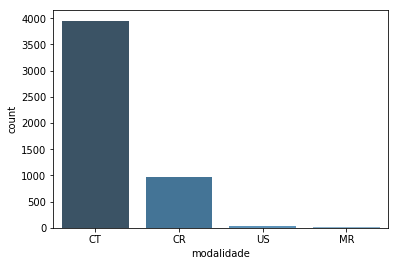

In [7]:
viz = Vizualization()
viz.bar_plot(df, 'modalidade', 0)

<b>Como a imagem demonstra CT é a modalidade de exame mais presente no dataset</b>

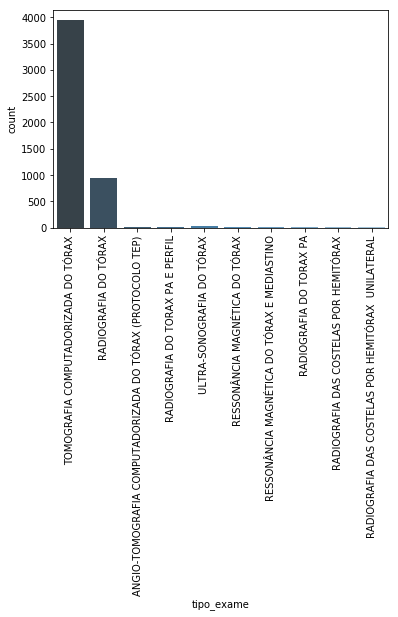

In [8]:
viz.bar_plot(df, 'tipo_exame', 90)

<b>Tomografia computadorizada é o tipo de exame mais recorrente no dado, é interessante observar que tanto para o tipo de exame e a modalidade as distribuições são desbalanceadas. Importante observar se existe predominancia dos tipos de exames em determinada modalidade para ver como o dado se mantém, observar se existem alguma correlação entre as informações</b>

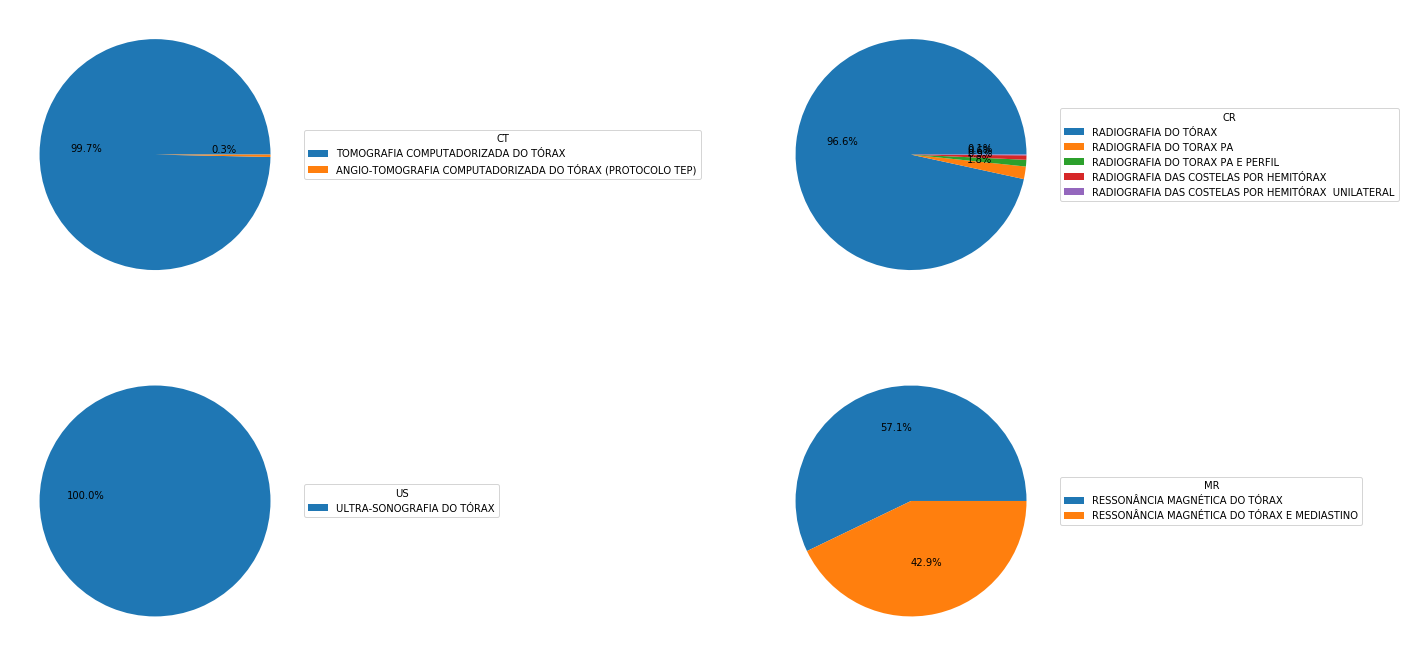

In [9]:
viz.pie_chart_multy(df)

<b>Todas as modalidade tem tipos de exames predominantes menos o MR que a divisão entre os exames está próxima da metade. Os tipo de exame dão um bom indicativo do que pode ser cada um dos tipos de exame, indicando que são diferentes exames para diferentes laudos, então vamos explorar o conteúdo textual desses laudos para observar se encontramos indicios dos diagnosticos</b>

## Análise de Processamento de linguagem natural.

<b>Primeramente vamos preprocessar o dado para iniciarmos as análises, o preprocessamento deste texto em questão se resume na remoção de pontuação, normalizando todo o texto passando para minusculo,remoção de stopwords e remoção de acentuação. Não foi aplicado nenhum processamento de normalização/redução de dimensionalidade das palavras como lemmatização e stemming pois como se trata de uma análise descritivo sobre o dado para melhor entendimento é importante que a palavra esteja em sua caracteização de escrita</b>

In [10]:
from tqdm import tqdm
tqdm.pandas()
textProcessing = TextPreprocessing()
df['laudo_completo'] = df['laudo_completo'].apply(lambda x : textProcessing.preprocesing(x))

In [11]:
df.head()

,docid,modalidade,tipo_exame,laudo_completo
0,189988,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,estudo tomografico computadorizado torax reali...
1,376443,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,realizados cortes tomograficos axiais tecnica ...
2,1843933,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,tecnica estudo tomografico computadorizado tor...
3,454421,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,estudo tomografico computadorizado torax reali...
4,61595,CT,TOMOGRAFIA COMPUTADORIZADA DO TÓRAX,realizada tomografia computadorizada torax aqu...


<b>Agora que o dado encontra-se preprocessa iremos começar a estudar o dado com base em suas features, iremos para isso sera aplicado o Bag of words para contar tanto as palavras mais frequentes quanto as combinações de features palavras com bigrams e trigrams.</b>

In [12]:
textMining = TextMining()
top_words = textMining.get_top_n_features(corpus=df['laudo_completo'], n =50)

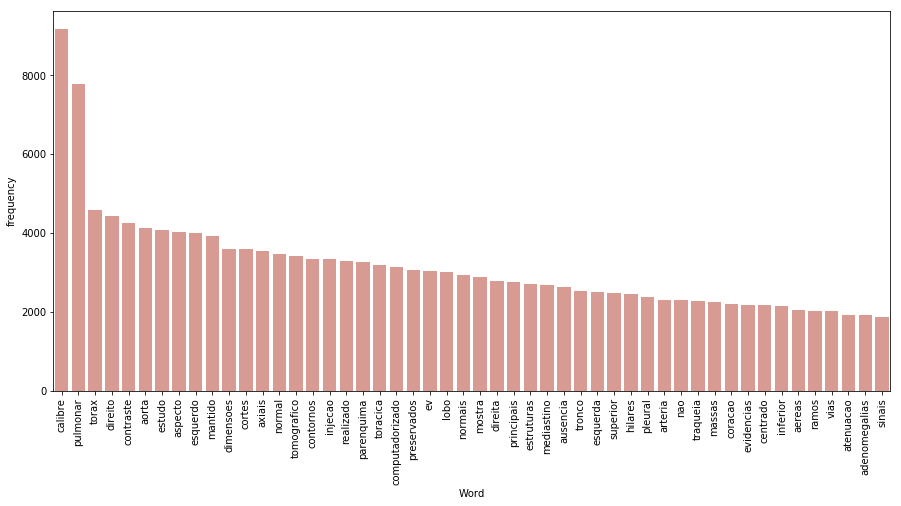

In [13]:
from matplotlib import rcParams
viz.bar_plot_top_words(top_words)

<b>A palavra mais frequente no texto é calibre mas esse ranking com as 50 palavras masi frequente não trás muita informação, apenas aquelas que mensionam partes do corpo como pulmonar e toráx, mas isso já é de se esperar baseado que os exames são focados nesta região do corpo, continuaremo a aplicação do BOW só que agora com Bigram</b>

In [14]:
bigram = textMining.get_top_n_features(corpus=df['laudo_completo'], n=50, ngram=(2, 2))
trigram = textMining.get_top_n_features(corpus=df['laudo_completo'], n=50, ngram=(3, 3))

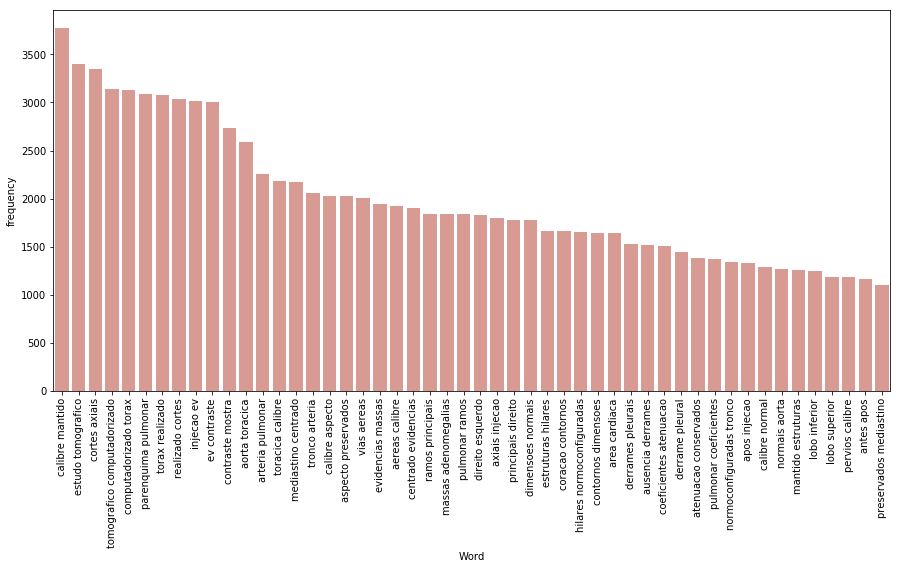

In [15]:
viz.bar_plot_top_words(bigram)

<b>Com aplicação do bigram começam surgir features interessantes como "estudo tomografico", "parenquima pulmonar","cortes axiais". Informações que caracterizam os exames e os tipos de informação que ficam contidas nos laudos, vamos tentar extrair mais informações com  trigram</b>

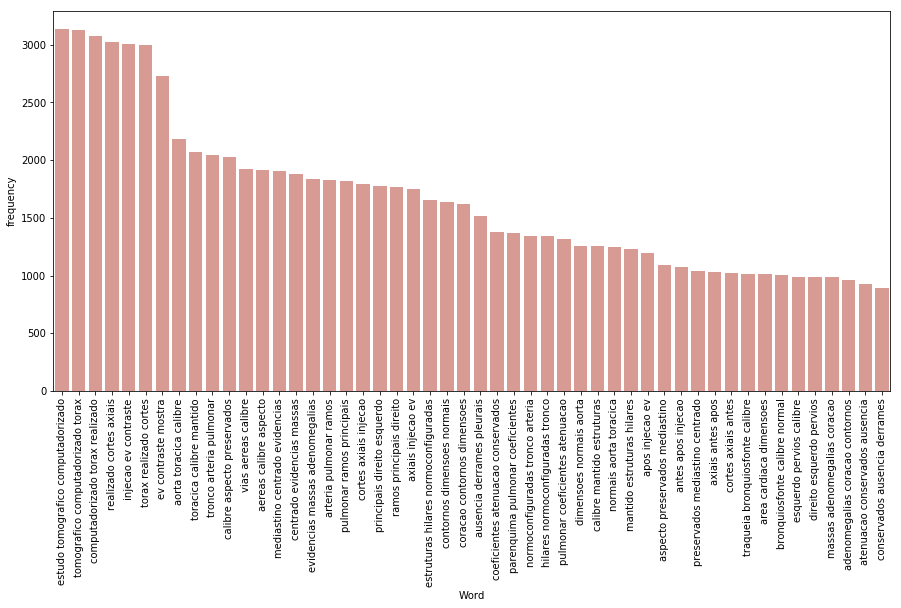

In [16]:
viz.bar_plot_top_words(trigram)

<b>Interessante notar como as informações com até os Trigans aparentam ser "genericas" no geral aparentam ser de uma especie de template para escrita dos laudos, não trazem informações de "achados" nos laudos como por exemplo, fraturase e lesão ... Então se torna necessário buscar mais fontes de informações, iremos fazer o levantamento de palavras chaves com o CHI2 baseado nos exames.</b>

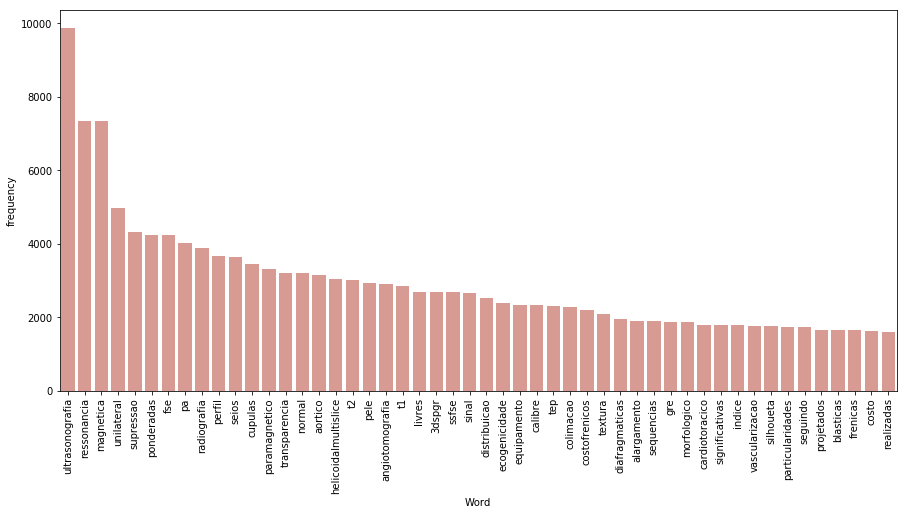

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import operator
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['laudo_completo'])
chi2score = chi2(X,df['tipo_exame'])[0]
wscores = dict(zip(vectorizer.get_feature_names(), chi2score))
dict_ = sorted(wscores.items(), key=operator.itemgetter(1), reverse=True)
viz.bar_plot_top_words(dict_[:50])

<b>As palavras chave de maiores relevancia ainda são palavras voltadas para exames como ultrassonografia, ressonancia, magnetica. Porém com atrelado a essas palavras semanticamente podeser que tenha tenha informações pertinentes, para tentar identificar esses aspectos irei aplica um modelo de embedding o Word2Vec, e irei testar baseado nas 9 primeiras palavras chaves outras palavras que mais se assemelham levando o contexto em que aparecem</b>

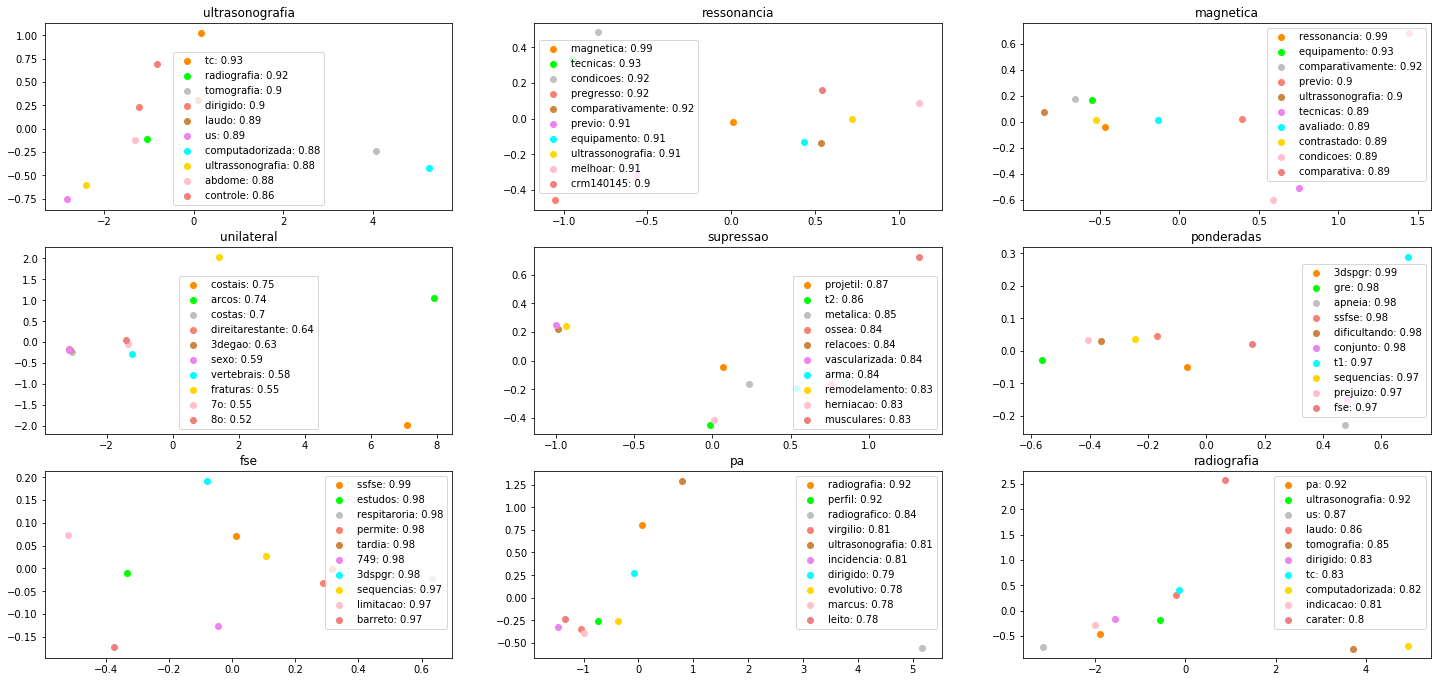

In [18]:
from gensim.models import Word2Vec
tokens = [word_tokenize(token) for token in df['laudo_completo']]
model = Word2Vec(tokens, size=100, window=3, min_count=1, workers=4)
viz.scatter_mult(dict_[:9], model)

<b> Os gráficos acima mostram nos titulos as palavras chave e nas legendas as palavras junto do seu indicie de similaridade entre os vetores das palavras, no scatterplot podemos ver também o quão distantes estão as palavras entre si, foi utilizado o PCA para reduzir a dimensionalidade das palavras para inserilas no plano euclideano 2D.</b>

* As palavras:
    * ultrasonografia
    * ressonancia 
    * magnetica
    * radiografia
tem associadas a elas realmente palavras que indicam o nome e tipo do exame ou a região que foi aplicada

* As palavras:
    * Unilateral
    * Supressão
Aparentemente dão indicativos de região que foram lesadas de alguma forma, pois surgem palavras como fraturas, exteriorização, costas e ossea.

* As demais palavras?
Apresentam informações das quais não consigo interpretar

<b> Iremos tentar agora separar nossos laudos por assunto na tentativa me melhor entender os assuntos e assim conseguir identificar melhor os possiveis diagnosticos. Para isso iremos utilizar o kmeans para separar nossos laudos em clusters e dentro de cada cluster aplicarei a modelagem de tópicos com LDA para identificar assim os assuntos. Primeiramente é necessário identificar em quantos clusters nosso dado pode se dividr, para isso iremos aplicar o método de elbow, para essa aplicações iremos vetorizar o texto com TFIDF na intenção de realçar as diferença entre textos diferentes e manter as características dos que são semelhantes, por causa do calculo do idf. </b>

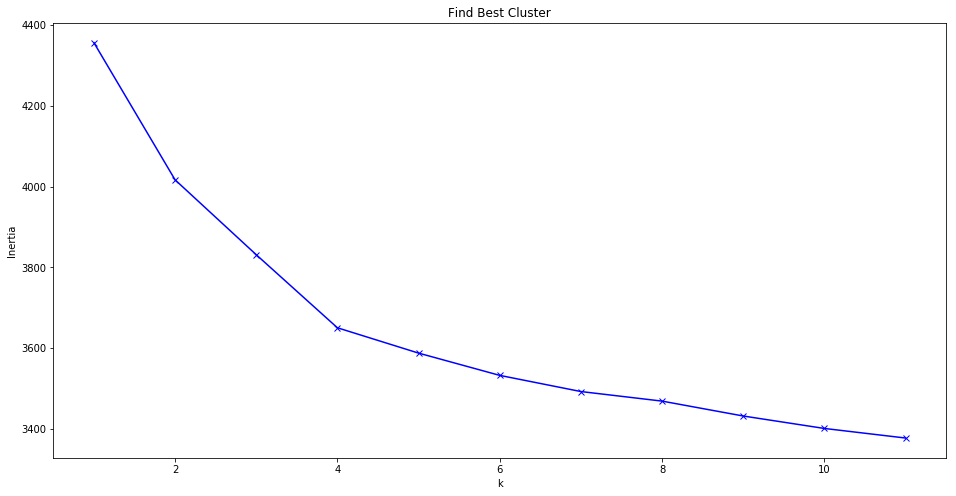

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
distortions = []
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['laudo_completo'])
K = range(1,12)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, n_jobs=4, random_state=42)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Find Best Cluster')
plt.show()

<b> Aplicando o método de elbow podemos identifcar o dado se divide em 4 clusters, iremos agora separar o dado nestes cluster e observar seus assuntos utilizando modelagem de tópicos.</b>

In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['laudo_completo'])
kmeanModel = KMeans(n_clusters=4, n_jobs=4, random_state=42)
kmeanModel.fit(X)
df['clusters'] = kmeanModel.labels_

In [22]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt  
from sklearn.decomposition import LatentDirichletAllocation

def topics(model, feature_names, no_top_words):
    dict_ = {}
    for topic_idx, topic in enumerate(model.components_):
        dict_[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return dict_

def plot_clouds(dict_, title):
    for topic, words in zip(dict_.keys(), dict_.values()):
        cloud = " ".join(words)
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white',  
                        min_font_size = 10).generate(cloud) 
  
        plt.figure(figsize = (4, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title(title + ' Topics '+ str(topic))
        plt.show() 

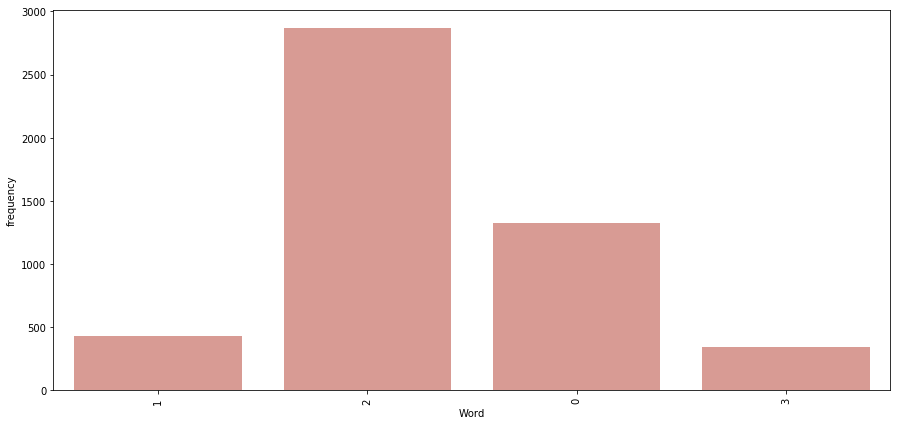

In [23]:
clusters_dict = list(zip(list(df['clusters'].value_counts().keys()), list(df['clusters'].value_counts().values)))
viz.bar_plot_top_words(clusters_dict)

<b>Nos clusters com mais amostras iremos aplicar a modelagem com 5 tópicos e nos com menos amostras apenas 2 tópicos para assim tentar abrangem melhor os assuntos contidos neles.</b>

In [24]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[df['clusters']==0]['laudo_completo'])
lda_cluster0 = LatentDirichletAllocation(random_state=42, n_components=5).fit(X)
topic_lda_cluster0 = topics(lda_cluster0, vectorizer.get_feature_names(), 15)

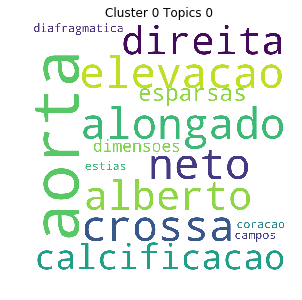

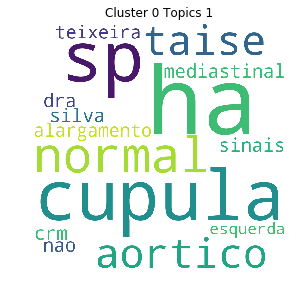

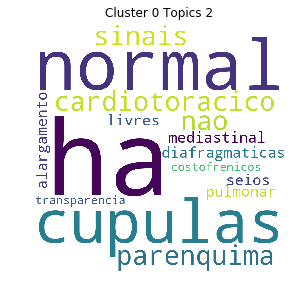

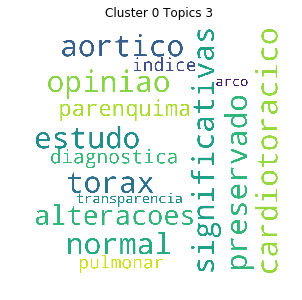

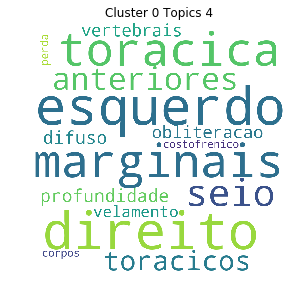

In [25]:
plot_clouds(topic_lda_cluster0, 'Cluster 0' )

#### Cluster 0 
* Tópico 1 :
  * São laudos voltados para ações recorrentes no coração e existem alguns nomes de pessoas que podem ser ou o nome dos médicos ou os nomes dos pacientes. Mas é um dado relativamente inviesado para determinados individuos.
* Tópico 2 :
  * São laudos que aparentemente foram redigidos por uma determinada médica que trata que trata de regiões próximas ao coração devido as palavras aórtico e meastinal.
* Tópico 3:
  * Aparentemente de se trata de resultados normais 
* Tópico 4:
  * Poderia ser resultados normais em relação a exames no torax, pulmão e aorta
* Tópico 5 :



In [26]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[df['clusters']==1]['laudo_completo'])
lda_cluster0 = LatentDirichletAllocation(random_state=42, n_components=2).fit(X)
topic_lda_cluster0 = topics(lda_cluster0, vectorizer.get_feature_names(), 15)

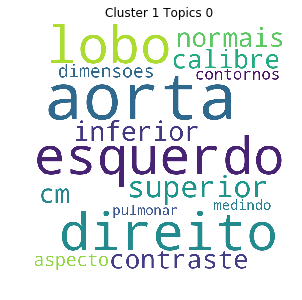

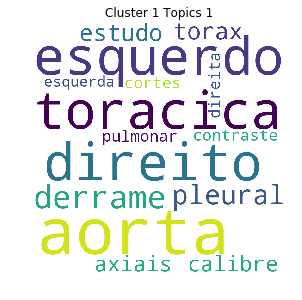

In [27]:
plot_clouds(topic_lda_cluster0, 'Cluster 1' )

#### Cluster 0
* Tópico 1 :
    * aparentemente pode-se tratar de resultados normais focados nas região inferior de partes do toráx.
* Tópico 2 :
    * Aparentemente trata já de lesões no pulmão devido a palavra derrame, pulmonar e pleural e é independete da região, pode ser na direita e esquerda

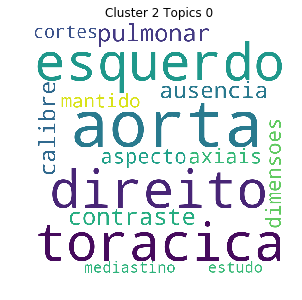

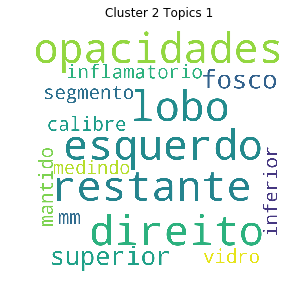

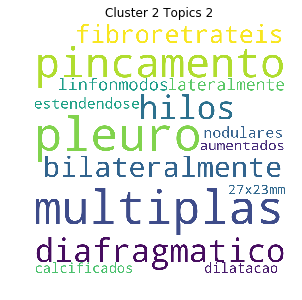

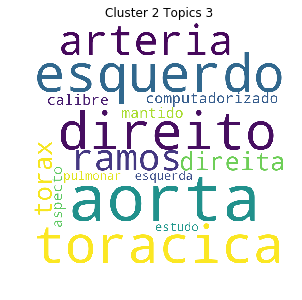

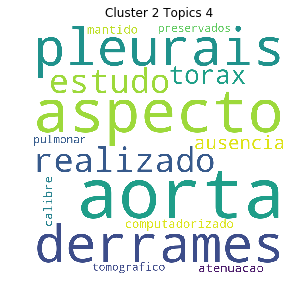

In [28]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[df['clusters']==2]['laudo_completo'])
lda_cluster0 = LatentDirichletAllocation(random_state=42, n_components=5).fit(X)
topic_lda_cluster0 = topics(lda_cluster0, vectorizer.get_feature_names(), 15)
plot_clouds(topic_lda_cluster0, 'Cluster 2')

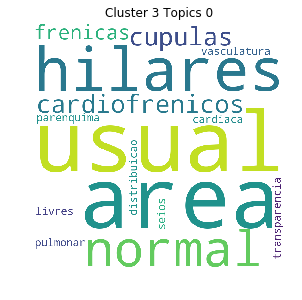

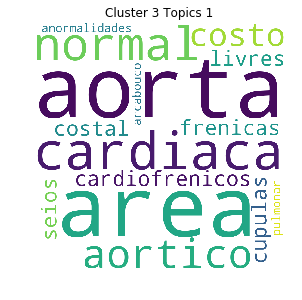

In [29]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[df['clusters']==3]['laudo_completo'])
lda_cluster0 = LatentDirichletAllocation(random_state=42, n_components=2).fit(X)
topic_lda_cluster0 = topics(lda_cluster0, vectorizer.get_feature_names(), 15)
plot_clouds(topic_lda_cluster0, 'Cluster 3' )

#### Cluster 3 :
   * Tópico 1 :
     * Dá a entender que se trata de situações normais na área cardiaca devido as palavras livre e normal
   * Tópico 2 :
      * Dá a entender que se trata de situações normais na área pulmonar e cardiaca deve ser por causa de regiões próximas e talvez mais voltado para mulheres devido a palavra seio, anormalidade aparece ali mas não conseguo deduzir do que se trata.
   

### Reconhecimento de entidades nomeadas

<b>Para a realização do NER, apliquei o Spacy porém a intenção era reconhecer entidades "médicas" e o modelo do spacy não tinha essa funcionalidade, tentei utizar o scispacy mas só tinha modelo treinado em inglês, tentei utilizar uma variação do BERT a BioBert para reconher o NER porém não tive hardware para realizar essa operação. Com isso finalizo a análise</b>